# Исследование поведения пользователей мобильного приложения.

Описание проекта.

Стартап, занимающийся продажей продуктов питания, разбирается в поведении пользователей своего мобильного приложения. Дизайнеры предложили измение шрифта во всём приложении, менеджеры посчитали, что такое нововведение неблагоприятно скажется на поведении пользователей. Было принято решение проведения А/В теста. Пользователи разбиты на три группы, две контрольные и одну эспериментальную.

Цель проекта :

Изучение воронки событий пользователей мобильного приложения, анализ проведенного А/А/В теста.

Входные данные для анализа: /datasets/logs_exp.csv.


Ход исследования:  

    Обзор данных
    Предобработка данных
    Изучение и проверка данных
    Анализ воронки событий
    Анализ результатов эксперимента
    Вывод


## Обзор данных

In [1]:
# импортируем библиотеки
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import graph_objects as go
import kaleido
import plotly.io as pio
pio.renderers.default = "png"
import datetime as dt
import numpy as np
import math as mth
from scipy import stats as st
import warnings; warnings.filterwarnings(action = 'ignore') 

Напишем функцию `description` на вход она должна получить имя таблицы и количество наблюдей, которые нужно вывести для ознакомления. На выходе вернёт случайно выбранные наблюдения, таблицу с постолбцовым описанием данных, диапазон индексов и общее число записей таблицы.

In [2]:
def description(data, ns): 
    descripted_data = pd.DataFrame({'Количество наблюдений': data.count(),
                                    'Количество уникальных значений': data.nunique(),
                                 'Количество пропусков': data.isna().sum(), 
                                 'Доля пропусков': round(data.isna().sum() / len(data), 2), 
                                 'Тип данных': data.dtypes})
    display(data.sample(ns))
    display(descripted_data)
    print(f'Диапазон индексов таблицы: {data.index.min()} - {data.index.max()}')
    print(f'Количестов записей в таблице: {len(data)}')

In [3]:
#загруззка файла с данными
pth1 = 'logs_exp.csv'
pth2 = '/datasets/logs_exp.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, sep='\t')
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, sep='\t')
else:
    print('Something is wrong')

Просмотриим данные

In [4]:
description(data,10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
106276,OffersScreenAppear,935788065062565859,1564862178,248
17586,MainScreenAppear,4358497452144799972,1564660473,247
228446,CartScreenAppear,5779903777733962844,1565182845,247
220449,MainScreenAppear,4229497205630462633,1565167280,248
98164,MainScreenAppear,6940614918004530662,1564846567,246
209696,CartScreenAppear,907516373885804773,1565118506,246
118969,CartScreenAppear,7997218022319749424,1564914861,248
104834,CartScreenAppear,6984427171264510079,1564858708,247
165073,PaymentScreenSuccessful,4705890939205361551,1565019118,246
51524,MainScreenAppear,1545896428940364595,1564740746,246


,Количество наблюдений,Количество уникальных значений,Количество пропусков,Доля пропусков,Тип данных
EventName,244126,5,0,0.0,object
DeviceIDHash,244126,7551,0,0.0,int64
EventTimestamp,244126,176654,0,0.0,int64
ExpId,244126,3,0,0.0,int64


Диапазон индексов таблицы: 0 - 244125
Количестов записей в таблице: 244126


Таблица `logs_exp` содержит 244126 наблюдений о посещениях пользователей:  


    EventName — название события;
    DeviceIDHash — уникальный идентификатор пользователя;
    EventTimestamp — дата и время события;
    ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


### Вывод

Данные загружены. Таблица содержит  244126 наблюдений о посещениях пользователей с 4 признаками имя события, идентификатор пользователя, дата и время события, номер группы. Пропущенных значений нет. Необходимо привести названия столбцов к единому читабельному стилю, привести данные в столбце в датой и временем к типу datetime, выделить дату в отдельный столбец для дальнейшего анализа, проверить наличие явнях дубликатов и корректность попадания в группы.

## Предообработка данных

Приведём названия столбцов к единому стилю.

In [5]:
data = data.rename(columns={
    'EventName':'event_name', 'DeviceIDHash':'id',
    'EventTimestamp':'event_dt', 'ExpId':'exp_id'
     })
data.columns

Index(['event_name', 'id', 'event_dt', 'exp_id'], dtype='object')

Проверим наличие явных дубликатов

In [6]:
print(f'Количество строк-дубликатов: {data.duplicated().sum()}')
print("Доля дубликатов:{0:.3f}".format(data.duplicated().sum()/ len(data)))

Количество строк-дубликатов: 413
Доля дубликатов:0.002


Обнаружены 413 строк дубликатов, удалим их, перезапишем индексы таблиц и проверим результат.

In [7]:
data = data.drop_duplicates().reset_index(drop=True)
print(f'Количество строк-дубликатов: {data.duplicated().sum()}')


Количество строк-дубликатов: 0


Приведём тип данных столбца с датой и временем к типу datetime.

In [8]:
data['event_dt'] = pd.to_datetime(data['event_dt'] , unit='s')

Создадим дополнительный столбец с датой

In [9]:
data['date'] = data['event_dt'].dt.floor('D') 

<a id='verify'></a> [Проверим](#verify) нет ли у нас пользователей попавших в несколько групп.

In [10]:
print(f"Количество пользователей, которые попали в обе группы:\
 {len(data.groupby('id').agg({'exp_id':'nunique'}).query('exp_id>1'))}")

Количество пользователей, которые попали в обе группы: 0


Для удобстава работы, добавим столбец с названием группы 246 - А1, 247 - А2, 248 - В. Проверим правильность присвоения.

In [11]:
def name_group(group):
    if group == 246:
        return 'A1'
    elif group == 247:
        return 'A2'
    elif group == 248:
        return 'B'
    else:
        return 'unknown_id'

data['group'] = data['exp_id'].apply(name_group)
data['group'].unique()   

array(['A1', 'B', 'A2'], dtype=object)

<a id ='verify'></a> Проверим корректность всех изменений.

In [12]:
description(data,5)

,event_name,id,event_dt,exp_id,date,group
70277,MainScreenAppear,6762259335237104420,2019-08-02 18:59:12,247,2019-08-02,A2
52914,CartScreenAppear,6598157157289930061,2019-08-02 10:57:07,247,2019-08-02,A2
7035,MainScreenAppear,911020573099466450,2019-08-01 06:34:43,248,2019-08-01,B
70389,CartScreenAppear,3232862589910296305,2019-08-02 19:02:30,246,2019-08-02,A1
190790,PaymentScreenSuccessful,4488981949755449740,2019-08-06 11:12:12,248,2019-08-06,B


,Количество наблюдений,Количество уникальных значений,Количество пропусков,Доля пропусков,Тип данных
event_name,243713,5,0,0.0,object
id,243713,7551,0,0.0,int64
event_dt,243713,176654,0,0.0,datetime64[ns]
exp_id,243713,3,0,0.0,int64
date,243713,14,0,0.0,datetime64[ns]
group,243713,3,0,0.0,object


Диапазон индексов таблицы: 0 - 243712
Количестов записей в таблице: 243713


### Вывод

Названия столбцов изменены, удалено 413 строк-дубликатов, столбец с датой и временем приведён к необходимому типу, добавлен столбец с датой без времени, проверено попадание пользователей в единственную группу. Добавлен столбец с упрощенным обозначением групп. После обработки таблица содержит 243713 наблюдений. Можно приступать к изучению данных.

## Изучение и проверка данных

Выведем общее количество наблюдений, пользователей и среднее количество наблюдений на пользователя.

In [13]:
print(f'Общее количество событий: {len(data)}')
print(f"Количество пользователей: {data['id'].nunique()}")
print("Среднее число действий на пользователя: {0:.0f}".format(len(data) / data['id'].nunique()))
print("Медианное число действий на пользователя: {0:.0f}". format(data.groupby('id')['event_name'].count().median()))

Общее количество событий: 243713
Количество пользователей: 7551
Среднее число действий на пользователя: 32
Медианное число действий на пользователя: 20


Судя по разнице между средним и медианным количеством действий на пользователя, есть несколько особо активных пользвателей. 

Определим период за который представлены данные

In [14]:
print(f"Дата первого наблюдения: {data['event_dt'].min()}")
print(f"Дата последнего наблюдения: {data['event_dt'].max()}")
print(f"Продолжительность наблюдений: {(data['event_dt'].max() - data['event_dt'].min())}")

Дата первого наблюдения: 2019-07-25 04:43:36
Дата последнего наблюдения: 2019-08-07 21:15:17
Продолжительность наблюдений: 13 days 16:31:41


Данные представлены за период с 25 июля 2019 года по 7 августа 2019. Продолжительность периода составляет 13 дней. Проверим как распределены данные во времени.

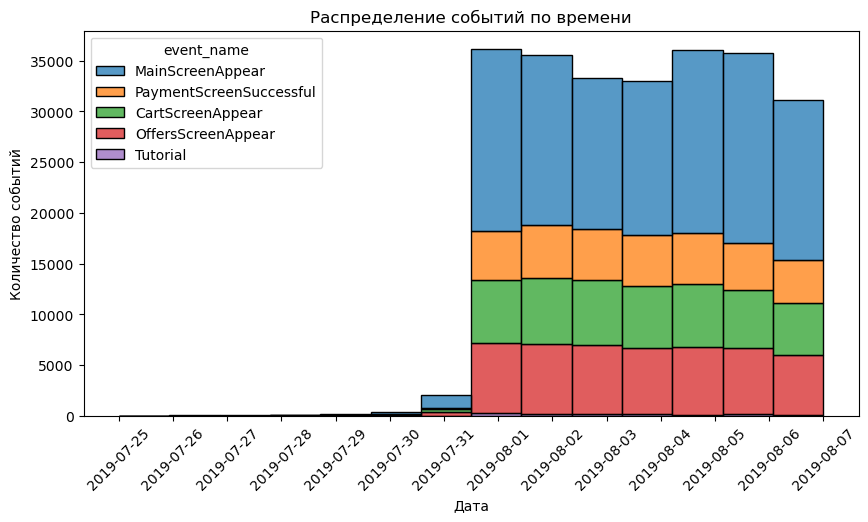

In [15]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(data = data, x = 'date', bins = data['date'].nunique(), hue ='event_name', multiple="stack")
plt.title('Распределение событий по времени')
plt.xticks(data['date'].unique(), rotation = 45)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

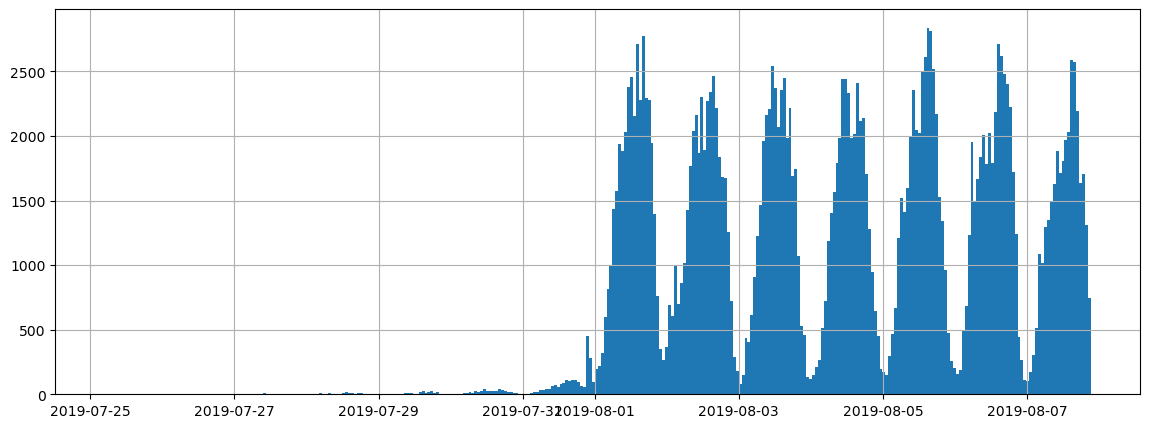

In [16]:
data['event_dt'].hist(bins=14*24, figsize=(14, 5));

Из гистограммы видно, что данные не являются одинакоко полными за весь период. Практически нет данных с 25 по 31 июля. 1 августа количество наблюдений резко выросло до примерно 36 тысяч и сохраняется на высоком уровне до конца периода наблюдений. Скорее всего данные первой недели это догруженные события из прошлого, полными данными будем считать события за период с 01.08.2019 по 07.08.2019. Устаревшие данные отфильтруем.

Создадим таблицу `data_clear`, в которую войдут данные после 31.07.2019.

In [17]:
data_clear = data.query('date>"2019-07-31"')

Проверим какое количество и процент данных мы отбросили.

In [18]:
print(f'Количество очищенных наблюдений: {len(data)-len(data_clear)}')
print('Процент отброшенных наблюдений: {0:.1%}'.format((len(data)-len(data_clear))/len(data)))
print(f"Количество очищенных пользователей:{data['id'].nunique()-data_clear['id'].nunique()}")
print('Процент отброшенных пользователей: {0:.1%}'.format((data['id'].nunique()-data_clear['id'].nunique())
                                                       /data['id'].nunique()))
print(f"Процент отброшенных пользователей по группам:")
      
(data.groupby('group').agg({'id':'nunique'})['id']
      -data_clear.groupby('group').agg({'id':'nunique'})['id'])/data.groupby('group').agg({'id':'nunique'})['id']

Количество очищенных наблюдений: 2826
Процент отброшенных наблюдений: 1.2%
Количество очищенных пользователей:17
Процент отброшенных пользователей: 0.2%
Процент отброшенных пользователей по группам:


group
A1    0.002009
A2    0.002778
B     0.001967
Name: id, dtype: float64

После очистки данных мы удалили 2826 наблюдей, что составляет 1.2% от исходного количества и 17 пользователей(0.2%). Внутри групп потери пользователей  от 0.19% до 0.27%. Проверим количество пользователей и действий в группах.

In [19]:
data_clear.pivot_table(index = 'group', values='id', aggfunc = ['nunique','count'], margins = True)

,nunique,count
,id,id
group,,
A1,2484,79302
A2,2513,77022
B,2537,84563
All,7534,240887


Количество пользователей и событий достаточно равномерно распределены по группам.

### Вывод

В данных содержалось 243713 наблюдений и 7551 уникальный пользователь. В среднем на одного пользователя приходится 32 события. Данные предоставлены за период с 25 июля по 07 августа 2019 года. После проверки было выявлено, что полные данные представлены лишь за период с 01 августа, устаревшие данные отброшены. После очистки осталось 240887 наблюдений и 7534 пользователя. Потери составили 1,2% наблюдений и 0.2% пользователей. Количество наблюдений и пользователей достаточно равномерно распределены по группам, на группу В приходится чуть большая часть.

## Анализ воронки событий

Создадим таблицу `user_event` сгруппированную посбытиям, выведем количиством наблюдений, количсетво пользователей и долю пользователей.

In [20]:
user_event = (data_clear
              .pivot_table(index = 'event_name', values = 'id', aggfunc = ['count', 'nunique'])
              .reset_index())
user_event.columns=['event_name','count', 'user_count']
user_event['%_users_per_all'] = round(user_event['user_count']/data_clear['id'].nunique()*100,2)
user_event = user_event.sort_values(by='user_count', ascending = False).reset_index(drop=True)
user_event

,event_name,count,user_count,%_users_per_all
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


Мы видим, что у нас представлены пять событий:
    

    MainScreenAppear - главный экран
    OffersScreenAppear - экран предложений
    CartScreenAppear - экран корзины
    PaymentScreenSuccessful - экран успешной оплаты
    Tutorial - обучающий экран
Исходя из сводной таблицы и логики, можно сделать вывод, что изначально пользователь попадает на главный экран, с него он может перейти на экран предложений, с экрана предложений на экран корзины, далее на экран успешной оплаты. По данным сложно определить с каких экранов можно перейти на обучающий экран, возможно, с любых, также возможно, что для новых пользователей изначально открывается обучающий экран, так как не все пользователи проходили этот этап, кто-то мог остановился на обучающем экране.

Воронка событий представляется следующим образом: главный экран -> экран предложений -> экран корзины -> экран успешной оплаты.

Удалим из таблицы строку с обучающим экраном (Tutorial) и посчитаем процент перещедших с предыдушего шага на следующийи процент потерявшихся пользоваелей.

In [21]:
user_event = user_event[user_event['event_name'] != 'Tutorial']
user_event['%_per_previous'] = round(user_event['user_count']/user_event['user_count'].shift(1)*100,2)
user_event['%_lost_per_previous'] = 100 - user_event['%_per_previous']
user_event

,event_name,count,user_count,%_users_per_all,%_per_previous,%_lost_per_previous
0,MainScreenAppear,117328,7419,98.47,NaN,NaN
1,OffersScreenAppear,46333,4593,60.96,61.91,38.09
2,CartScreenAppear,42303,3734,49.56,81.30,18.70
3,PaymentScreenSuccessful,33918,3539,46.97,94.78,5.22


Как видно из таблицы с главного экрана до экрана успешной оплаты доходит почти 47% пользователей, больше всего пользователей теряется на этапе перехода от главного экрана к экрану предложений примерно 38%. От экрана предложений к экрану корзины переходит 81%. Почти все пользователи перещедшие в экран корхины, а именно 95%, переходят к экрану успешной оплаты. 

Визуализируем воронку событий 

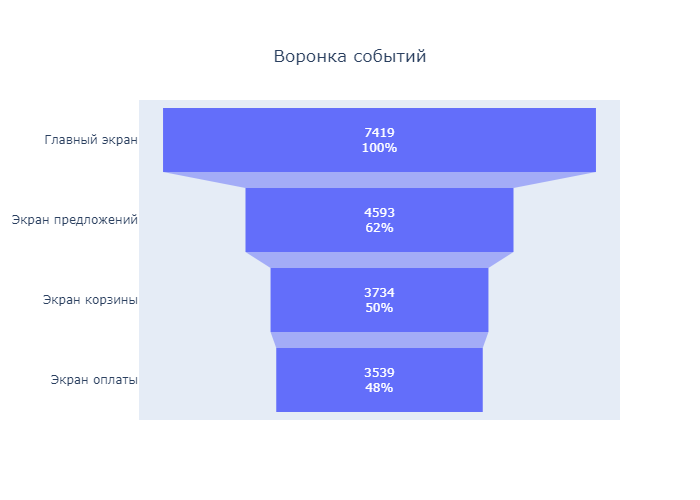

In [22]:
fig = go.Figure(go.Funnel(y = ['Главный экран','Экран предложений','Экран корзины','Экран оплаты'],
                          x = user_event['user_count'],
                          textposition = 'inside',
                          textinfo = 'value + percent initial'
                         ))
fig.update_layout(title={
        'text': "Воронка событий",
        'y':0.9,
        'x':0.5}
)
fig.show()

### Вывод

В данных содержатся 5 событий (главный экран, экран предложений, экран корзины, экран успешной оплаты и обучающий экран). Обучающий экран был исключён из воронки событий, неизвестно в какой момент пользователь на него попадает. Последовательность воронки событий следющая: главный экран -> экран предложений -> экран корзины -> экран успешной оплаты. До экрана оплаты с главного экрана из 7419 доходит 48% или 3539 пользователей. Большая часть (38%) теряется при переходе с главного экрана к экрану предожений. Возможно, пользователи попадая на главный экран не видят заинтересовавших их товаров. Стоит проработать главный экран, провести анализ предпочтений пользователей и выводить на главный экран соответствующие карточки товаров.

## Анализ результатов эксперимента

Для анализа результатов необходимо будет сравнивать показатели между группами, для упрощения напишем функцию `diff_test`, которая будет проверять гипотезу о равенстве долей пользователей совершивших событие относительно общего количества в группе. На вход она будет получать две таблицы с данными по группам,наименование события и число проведенных экспериментов. Последний параметр необходим для снижения вероятности ошибки первого рода,так как у нас несколько групп и несколько параметров для сравнения необходимо применим поправку Бонферрони. Критический уровень статистической значимости зададим равным 0.05. 

In [23]:
def diff_test(data1, data2, event, n):
    alpha = 0.05
    
    cor_alpha = alpha/n
    trials = np.array([data1['id'].nunique(), data2['id'].nunique()])
    successes = np.array([data1[data1['event_name'] == event]['id'].nunique(), 
                        data2[data2['event_name'] == event]['id'].nunique()])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1])/(trials[0] + trials[1])
    difference = p1 - p2 
    z_value = difference/np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    
    print('Событие:', event)
    print('p_value: {0:.3f}'.format(p_value))
    if p_value < cor_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

<a id='comfunc'></a>

Критерии успешного A/A-теста: 

    Количество пользователей в различных группах различается не более, чем на 1%;
    Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
    Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
    Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

На этапе предобработки данных мы проверили, что нет пользователей попавших в несколько групп. На этапе анализа воронки мы выяснили, что обучающий экран не входит в воронку событий, однако здесь не стоит исключать данное событие, если при анализе А/В теста выявится существенная разница между долями пользователей перешедшими к обучающему экрану, это может быть знаком, что новые шрифты сказались на поведении пользователей.

In [24]:
data_clear.groupby(['group','exp_id']).agg({'id':'nunique'}).reset_index()

,group,exp_id,id
0,A1,246,2484
1,A2,247,2513
2,B,248,2537


В изначальных данных было представлено три группы 246 и 247 являлись контрольными, 248 экпериментальная, по этому принципу мы добавили имена А1, А2 и В. Выведем процентное соотношение разниц между группами.

In [25]:
group_A1 = data_clear[data_clear['group'] == 'A1']['id'].nunique()
group_A2 = data_clear[data_clear['group'] == 'A2']['id'].nunique()
group_B = data_clear[data_clear['group'] == 'B']['id'].nunique()
group_A = group_A1 + group_A2
print('Количество пользователей в группах A1 и A2 различается на {0:.1%}'.format(1- group_A1/group_A2))
print('Количество пользователей в группах A1 и В различается на {0:.1%}'.format(1- group_A1/group_B))
print('Количество пользователей в группах A2 и B различается на {0:.1%}'.format(1- group_A2/group_B))

Количество пользователей в группах A1 и A2 различается на 1.2%
Количество пользователей в группах A1 и В различается на 2.1%
Количество пользователей в группах A2 и B различается на 0.9%


Разница между контрольными группами состаляет чуть больше допустимого 1.2%. Самое большое различие в количестве пользователей между группами A1 и В 2.1%.

Создадим таблицу с количеством пользователей каждого шага в группах и процентом перешедших на следующий шаг относительно общего числа пользователей в группах

In [26]:
test_data = (data_clear.pivot_table(
    index='event_name', 
    columns='group', 
    values='id',
    aggfunc='nunique', margins = True)
           .sort_values(by='B', ascending=False)
           .reset_index()
          )
test_data['A'] = test_data['A1'] + test_data['A2']
test_data['%_converse_in_A1'] = round(test_data['A1']/group_A1*100,2)
test_data['%_converse_in_A2'] = round(test_data['A2']/group_A2*100,2)
test_data['diff_conv_A1_A2'] = test_data['%_converse_in_A1'] - test_data['%_converse_in_A2']
test_data['%_converse_in_B'] = round(test_data['B']/group_B*100,2)
test_data['%_converse_in_A'] = round(test_data['A']/group_A*100,2)
test_data

group,event_name,A1,A2,B,All,A,%_converse_in_A1,%_converse_in_A2,diff_conv_A1_A2,%_converse_in_B,%_converse_in_A
0,All,2484,2513,2537,7534,4997,100.00,100.00,0.00,100.00,100.00
1,MainScreenAppear,2450,2476,2493,7419,4926,98.63,98.53,0.10,98.27,98.58
2,OffersScreenAppear,1542,1520,1531,4593,3062,62.08,60.49,1.59,60.35,61.28
3,CartScreenAppear,1266,1238,1230,3734,2504,50.97,49.26,1.71,48.48,50.11
4,PaymentScreenSuccessful,1200,1158,1181,3539,2358,48.31,46.08,2.23,46.55,47.19
5,Tutorial,278,283,279,840,561,11.19,11.26,-0.07,11.00,11.23


Во всех группах набор событий одинаковый и для всех событий есть пользователи. По событиям экран предложений, экран корзины и экран успешной оплаты различия между группами А1 и А2 превышают 1%. 

Мы имеем четыре группы для сравнений и 5 событий, соответственно количество проверок равно 20. Это число мы передадим в функцию для корректировки значения критического уровня статистической значимости.
Сформулируем нулевую и альтернативную гипотезы:

    Н0: доли пользователей, перешедших к событию в группах равны.
    Н1: доли пользователей, перешедших к событию различаются.
Проверим есть ли различия в контрольных группах. Запустим цикл по всем событиям.

In [27]:
for event in data_clear['event_name'].unique():
    diff_test(data_clear[data_clear['group'] == 'A1'], data_clear[data_clear['group'] == 'A2'], event, 20)
    print()

Событие: Tutorial
p_value: 0.938
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p_value: 0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p_value: 0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p_value: 0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p_value: 0.115
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимых различий между контрольными группами нет ни по одному событию.

Проведенный А/А тест нельзя однозначно считать корректным так как
    
    различия по числу уникальных пользователей в группах различаются более чем на 1%. 
    различия в метрике конверсии из посетителя в покупателя, то естьпопадание на экран успешной оплаты между группами А1 и А2 составляет 2.23%.


Проанализируем показатели А/В теста. 
Сравним группу А1 и В.

In [28]:
for event in data_clear['event_name'].unique():
    diff_test(data_clear[data_clear['group'] == 'A1'], data_clear[data_clear['group'] == 'B'], event, 20)
    print()

Событие: Tutorial
p_value: 0.826
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p_value: 0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p_value: 0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p_value: 0.078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p_value: 0.212
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимых различий между контрольной группой А1 и экспериментальной В нет ни по одному из событий.

In [29]:
for event in data_clear['event_name'].unique():
    diff_test(data_clear[data_clear['group'] == 'A2'], data_clear[data_clear['group'] == 'B'], event, 20)
    print()

Событие: Tutorial
p_value: 0.765
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p_value: 0.459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p_value: 0.920
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p_value: 0.579
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p_value: 0.737
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимых различий между контрольной группой А2 и экспериментальной В нет ни по одному из событий.

Проверим есть ли различия между объединенной контрольной группой и экспериментальной.

In [30]:
for event in data_clear['event_name'].unique():
    diff_test(data_clear.query('group=="A1" or group=="A2" ') , data_clear[data_clear['group'] == 'B'], event, 20)
    print()

Событие: Tutorial
p_value: 0.765
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p_value: 0.294
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p_value: 0.434
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p_value: 0.182
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p_value: 0.600
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимых различий между объединенной контрольной группой А и экспериментальной В нет. Уровень статистической значимости значительно выше критического по всем событиям.

### Вывод

На этапе анализа А/А теста были зафиксированы нарушения корректности его проведения. Контрольные группы различаются на более чем 1% по количеству уникальных пользователей. Разница в проценте совершивших покупку составляет 2.23%. Однако, согласно результатам теста, статистической значмости в показателях между группами нет. 
При анализе А/В теста не зафиксировано ни одного статистически значимого различия между контрольными группами и группой В, аналогичный результат между объединенной контрольной группой и экспериментальной. Введение новых шрифтов никак не повлияло на поведение пользователей.

## Вывод

Проведен анализ воронки событий и А/А/В теста поведения пользователей мобильного приложения стартапа, занимающегося продажей продуктов питания. На вход был получен файл с логами о действиях пользователей /datasets/logs_exp.csv. Файл содержал 244126 наблюдение с 5 типам действий пользователей (просмотр главного экрана, просмотр экрана предложений, переход в экран корзины, попадание на экран успешной оплаты и переход на обучающий экран). Данные представлены за период с 25 июля 2019 года по 7 августа 2019.

В процессе предобработки данных было удалено 413 строк-дубликатов. Наименования столбцов приведены к единому стилю. Столбец содержащий информацию о дате и времени события приведет к типу datetime. Добавлен столбец с датой и столбец с новыми именами групп, контрольные группы получили названия А1 и А2, экспериментальная название В. Проверено попадание каждого пользователя в единственную группу.  
После предобработки в данных осталось 243713 наблюдение и 7551 уникальных пользователей. Медианное число действий на пользователя составляет 20, среднее 32, определенно у приложения есть активные лояльные пользователи. При изучении данных было обнаружено, что полные данные есть только за период с 01 по 07 августа 2019 года. Данные предыдушего периода были удалены, потери составили 2826 наблюдений (1.2%) и 17 пользователей (0.2%).

Воронка событий представляется следующим образом: главный экран -> экран предложений -> экран корзины -> экран успешной оплаты. С главного экрана к экрану успешной оплаты переходят 48% пользователей, это хороший показатель. Большая часть теряется на этапе перехода к экрану предложений 38%.

При анализе А/А теста были зафиксированы небольшие нарушения корректности его проведения,но статистически значимых различий между контрольными группами обнаружено не было.
При анализе А/В теста статистически значимых различиний так же не было обнаружено, как при сравнении экспериментальной группы с каждой из контрольных, так и экспериментальной с объединенными контрольными группами.
Можно сделать вывод, что изменение шрифтов никак не отразилось на поведении пользователей.